### ライブラリのインポート

In [1]:
import torch
from scipy.cluster.hierarchy import dendrogram, linkage, distance
import numpy as np

import ot

from scripts import w_pq_batch as w_pq
from scripts import trees, pq_gram, func

from pqgrams.PQGram import Profile
import pyconll, zss

from tqdm.notebook import tqdm_notebook as tqdm
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
x = [[1,2,3], [4,5,6], [7,8,9], [10,11,12], [13,14,15]]
sup = len(x)

for i in range(sup):
    tmp = x.copy()
    val = tmp.pop(i)
    tes = tmp.pop(i%len(tmp))
    tra = sum(tmp, [])
    print(tra, val, tes)
    
    

[7, 8, 9, 10, 11, 12, 13, 14, 15] [1, 2, 3] [4, 5, 6]
[1, 2, 3, 10, 11, 12, 13, 14, 15] [4, 5, 6] [7, 8, 9]
[1, 2, 3, 4, 5, 6, 13, 14, 15] [7, 8, 9] [10, 11, 12]
[1, 2, 3, 4, 5, 6, 7, 8, 9] [10, 11, 12] [13, 14, 15]
[4, 5, 6, 7, 8, 9, 10, 11, 12] [13, 14, 15] [1, 2, 3]


##### EWT,Atis間のWasserstein距離

In [3]:
train_tensors_path = "data/train_tensors_en_corpora_En_EWT_Atis_unlabel_50.pt"
train_labels_path = "data/train_labels_en_corpora_En_EWT_Atis_unlabel_50.pt"
train_indexes_path = "data/train_indexes_en_corpora_En_EWT_Atis_unlabel_50.pt"

valid_tensors_path = "data/valid_tensors_en_corpora_En_EWT_Atis_unlabel_50.pt"
valid_labels_path = "data/valid_labels_en_corpora_En_EWT_Atis_unlabel_50.pt"
valid_indexes_path = "data/valid_indexes_en_corpora_En_EWT_Atis_unlabel_50.pt"

test_tensors_path = "data/test_tensors_en_corpora_En_EWT_Atis_unlabel_50.pt"
test_labels_path = "data/test_labels_en_corpora_En_EWT_Atis_unlabel_50.pt"
test_indexes_path = "data/test_indexes_en_corpora_En_EWT_Atis_unlabel_50.pt"

model_path = "models/model_en_corpora_EWT_Atis_unlabel_50.pth"

CoNLLU_EWT_PATH = "corpora/English-EWT.conllu"
CoNLLU = pyconll.load_from_file(CoNLLU_EWT_PATH)
EWT_tree_count = len(CoNLLU)


In [8]:
train_tensors = torch.load(train_tensors_path)

In [10]:
distance_function = w_pq.WeightedPqgramDistance(train_tensors[0].size(), [], [])
distance_function.load_state_dict(torch.load(model_path))
distance_function.eval()
weights = distance_function.weights
weights

Parameter containing:
tensor([-2.0425, -2.2598, -1.7006, -2.2871, -2.0425,  0.3741, -1.7006, -1.7006],
       requires_grad=True)

In [7]:
a = [0.3, 0.7]  # ソース分布（サイズ2）
b = [0.4, 0.4, 0.2]  # ターゲット分布（サイズ3）
M = [[0.0, 1.0, 2.0],  # 2x3 のコスト行列
     [1.0, 0.5, 0.5]]

T = ot.emd2(a, b, M)
print("OTマトリックス:", T)

OTマトリックス: 0.39999999999999997


In [3]:
CoNLLU_GPT_PATH = "corpora/English-chatGPT.conllu"

In [4]:
CoNLLU += pyconll.load_from_file(CoNLLU_GPT_PATH)


PQ_Trees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLLU]
PQ_Index = [Profile(tree, p=2, q=2) for tree in PQ_Trees]

J = set(PQ_Index[0])
for pq_set  in PQ_Index[1:]:
    J = J.union(pq_set)
J = list(J)

tensors = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index, desc="[convert tensor]")]


[convert tensor]: 100%|██████████| 30015/30015 [00:00<00:00, 41490.56it/s]


In [5]:
len(J)

8

In [6]:
def wasserstein_distance_weighted(data1, data2, weights):
    # 重みを適用
    weights = func.softplus(weights)
    weighted_data1 = [t*weights for t in data1]  # 各サンプルに重みを適用
    weighted_data2 = [t*weights for t in data2]

    distances = []
    for dim in range(weighted_data1[0].size(0)):  # 8次元でループ
        # dim次元の要素を全て取得して連結
        x_dim = torch.cat([t[dim].unsqueeze(0) for t in weighted_data1])
        y_dim = torch.cat([t[dim].unsqueeze(0) for t in weighted_data2])

        # 次元ごとに要素をソート
        x_sorted = torch.sort(x_dim)[0]
        y_sorted = torch.sort(y_dim)[0]

        # 累積分布関数 (CDF) を計算
        cdf_x = torch.cumsum(torch.ones_like(x_sorted) / len(x_sorted), dim=0)
        cdf_y = torch.cumsum(torch.ones_like(y_sorted) / len(y_sorted), dim=0)

        # 各次元のWasserstein距離を計算
        distance = torch.mean(torch.abs(cdf_x - cdf_y))
        distances.append(distance)

    print(distances)
    # 各次元の距離の平均を返す
    return torch.mean(torch.tensor(distances)).item()


In [ ]:
distance_function = w_pq.WeightedPqgramDistance(tensors[0].size(), [], [])
distance_function.load_state_dict(torch.load(model_path))
distance_function.eval()
weights = distance_function.weights


WeightedPqgramDistance()

In [8]:
weights = distance_function.weights

In [9]:
print(min(EWT_tree_count, len(tensors)-EWT_tree_count))

13394


In [10]:
tensors_EWT = tensors[:EWT_tree_count]
tensors_GPT = tensors[EWT_tree_count:]
sample_size = min(EWT_tree_count, len(tensors)-EWT_tree_count)
if EWT_tree_count<sample_size:
    tensors_GPT = random.sample(tensors_GPT, k=sample_size)
else :
    tensors_EWT = random.sample(tensors_EWT, k=sample_size)

In [11]:
Tensors_EWT = torch.zeros((EWT_tree_count,8))
for i, tensor in enumerate(tensors_EWT):
    Tensors_EWT[i] = tensor

Tensors_GPT = torch.zeros((len(tensors_GPT),8))
for i, tensor in enumerate(tensors_GPT):
    Tensors_GPT[i] = tensor


In [12]:
def distance_matrix_chunked(tensors: np.ndarray, weights: np.ndarray, chunk_size: int):
    """
    データをチャンクに分割して距離行列を計算する関数。
    tensors: 入力データ [N, dim] の配列
    weights: 重み [dim] の配列
    chunk_size: 一度に処理するデータのチャンクサイズ
    """

    num_samples = tensors.shape[0]
    dist_mat = np.zeros((num_samples, num_samples))  # 距離行列の初期化
    
    # チャンクごとに計算
    for i in tqdm(range(0, num_samples, chunk_size)):
        end_i = min(i + chunk_size, num_samples)
        tensor_chunk_i = tensors[i:end_i, np.newaxis]  # [chunk_size, 1, dim]

        for j in range(0, num_samples, chunk_size):
            end_j = min(j + chunk_size, num_samples)
            tensor_chunk_j = tensors[j:end_j, np.newaxis]  # [1, chunk_size, dim]
            
            # 差の計算
            diff = np.abs(tensor_chunk_i - tensor_chunk_j)  # [chunk_size, chunk_size, dim]
            aw = np.log1p(np.exp(weights))  # weightsのSoftplus関数を近似
            aw = aw[np.newaxis, np.newaxis, :]  # [1, 1, dim]
            weighted_diff = diff * aw  # アダマール積
            dist_chunk = weighted_diff.sum(axis=2)  # 距離の計算
            
            # 距離行列に結果を格納
            dist_mat[i:end_i, j:end_j] = dist_chunk

    return dist_mat


In [13]:
array_EWT = Tensors_EWT.numpy()
array_GPT = Tensors_GPT.numpy()

weights_np = weights.detach().numpy()

array_size = len(array_EWT) + len(array_GPT)

array_all = np.zeros((array_size, 8))

print(len(array_EWT))

for i in range(len(array_EWT)):
    array_all[i] = array_EWT[i]

for i in range(len(array_GPT)):
    array_all[i+len(array_GPT)] = array_GPT[i]

16621


In [14]:
def distance_matrix_chunked(tensors: torch.Tensor, weights: torch.Tensor, chunk_size: int):
    """
    データをチャンクに分割して距離行列を計算する関数。
    tensors: 入力データ [N, dim] のテンソル
    weights: 重み [dim] のテンソル
    chunk_size: 一度に処理するデータのチャンクサイズ
    """
    device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

    num_samples = tensors.shape[0]
    dist_mat = torch.zeros((num_samples, num_samples), device=device)  # 距離行列の初期化
    
    # チャンクごとに計算
    for i in range(0, num_samples, chunk_size):
        end_i = min(i + chunk_size, num_samples)
        tensor_chunk_i = tensors[i:end_i].unsqueeze(1)  # [chunk_size, 1, dim]

        for j in range(0, num_samples, chunk_size):
            end_j = min(j + chunk_size, num_samples)
            tensor_chunk_j = tensors[j:end_j].unsqueeze(0)  # [1, chunk_size, dim]
            
            # 差の計算
            diff = torch.abs(tensor_chunk_i - tensor_chunk_j).to(device)  # [chunk_size, chunk_size, dim]
            aw = func.softplus(weights).to(device).unsqueeze(0).unsqueeze(0)  # [1, 1, dim]
            weighted_diff = diff * aw  # アダマール積
            dist_chunk = weighted_diff.sum(dim=2)  # 距離の計算
            
            # 距離行列に結果を格納
            dist_mat[i:end_i, j:end_j] = dist_chunk
        del dist_chunk, end_j, aw, weighted_diff
        torch.cuda.empty_cache()
    
    del tensors, end_i
    torch.cuda.empty_cache()

    return dist_mat

In [15]:
distance_matrix=distance_matrix_chunked(torch.from_numpy(array_all), weights, len(tensors)//512)
torch.cuda.empty_cache()

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 3 has a total capacity of 23.65 GiB of which 3.19 MiB is free. Including non-PyTorch memory, this process has 23.64 GiB memory in use. Of the allocated memory 21.73 GiB is allocated by PyTorch, and 1.47 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [16]:
distance_matrix = np.zeros((array_size,array_size))

for i in tqdm(range(array_size)):
    for j in range(array_size):
        dist = weighted
        distance_matrix[i][j] = 

In [15]:
distance_matrix_chunked(array_all, weights_np, len(array_all)//128)

  0%|          | 0/129 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (234,1,8) (63,1,8) 

In [27]:
def compute_cost_matrix(data, distance_func):
    num_points = data.shape[0]
    cost_matrix = np.zeros((num_points, num_points))

    for i in range(num_points):
        for j in range(num_points):
            if i != j:
                cost_matrix[i, j] = distance_func(data[i], data[j])
    
    return cost_matrix

In [ ]:
cost_matrix = compute_cost_matrix(data_a, custom_distance)

### Wasserstein距離の計測

#### English-EWT, chatGPT

In [ ]:
CoNLLU_EWT_PATH = "corpora/English-EWT.conllu"
CoNLLU = pyconll.load_from_file(CoNLLU_EWT_PATH)
EWT_tree_count = len(CoNLLU)

CoNLLU_GPT_PATH = "corpora/English-chatGPT.conllu"
CoNLLU += pyconll.load_from_file(CoNLLU_GPT_PATH)
GPT_tree_count = len(CoNLLU) - EWT_tree_count


PQ_Trees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLLU]
PQ_Index = [Profile(tree, p=2, q=2) for tree in PQ_Trees]

J = set(PQ_Index[0])
for pq_set  in PQ_Index[1:]:
    J = J.union(pq_set)
J = list(J)

tensors_EWT = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[:EWT_tree_count], desc="[convert tensor]")]
tensors_GPT = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[EWT_tree_count:], desc="[convert tensor]")]


model_path = "models/model_en_corpora_EWT_Atis_unlabel_50.pth"
distance_function = w_pq.WeightedPqgramDistance(tensors_EWT[0].size(), [], [])
distance_function.load_state_dict(torch.load(model_path))
distance_function.eval()
weights = distance_function.weights


In [3]:
a = []
for _ in range(EWT_tree_count):
    a.append(1/EWT_tree_count)
b = []
for _ in range(GPT_tree_count):
    b.append(1/GPT_tree_count)

In [4]:
cost_matrix = torch.zeros((EWT_tree_count, GPT_tree_count))

tensors_EWT = torch.stack([t.to("cuda") for t in tensors_EWT])
tensors_GPT = torch.stack([t.to("cuda") for t in tensors_GPT])

for i in tqdm(range(EWT_tree_count)):
    t_ewt = tensors_EWT[i].unsqueeze(0)
    cost_matrix[i] = w_pq.weighted_pqgram_distance_batch(weights, tensors_GPT, t_ewt.repeat(tensors_GPT.size(0), 1))

  0%|          | 0/16621 [00:00<?, ?it/s]

In [7]:
ot.emd2(a, b, cost_matrix.detach().numpy(), numItermax=1000000)

1.5900653316080489

### EWT - EWT

In [2]:
CoNLLU_source_PATH = "corpora/English/English-EWT.conllu"
CoNLLU = pyconll.load_from_file(CoNLLU_source_PATH)
source_tree_count = len(CoNLLU)

CoNLLU_target_PATH = "corpora/English/English-EWT.conllu"
CoNLLU += pyconll.load_from_file(CoNLLU_target_PATH)
target_tree_count = len(CoNLLU) - source_tree_count


PQ_Trees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLLU]
PQ_Index = [Profile(tree, p=2, q=2) for tree in PQ_Trees]

J = set(PQ_Index[0])
for pq_set  in PQ_Index[1:]:
    J = J.union(pq_set)
J = list(J)

tensors_source = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[:source_tree_count], desc="[convert tensor]")]
tensors_target = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[source_tree_count:], desc="[convert tensor]")]


model_path = "models/model_en_corpora_EWT_EWT_unlabel_50.pth"
distance_function = w_pq.WeightedPqgramDistance(tensors_source[0].size(), [], [])
distance_function.load_state_dict(torch.load(model_path))
distance_function.eval()
weights = distance_function.weights

a = []
for _ in range(source_tree_count):
    a.append(1/source_tree_count)
b = []
for _ in range(target_tree_count):
    b.append(1/target_tree_count)

cost_matrix = torch.zeros((source_tree_count, target_tree_count))

tensors_source = torch.stack([t.to("cuda") for t in tensors_source])
tensors_target = torch.stack([t.to("cuda") for t in tensors_target])

for i in tqdm(range(source_tree_count), desc="[cost matrix]"):
    t_source = tensors_source[i].unsqueeze(0)
    cost_matrix[i] = w_pq.weighted_pqgram_distance_batch(weights, tensors_target, t_source.repeat(tensors_target.size(0), 1))

print(ot.emd2(a, b, cost_matrix.detach().numpy(), numItermax=1000000))

[convert tensor]:   0%|          | 0/16621 [00:00<?, ?it/s]

[convert tensor]:   0%|          | 0/16621 [00:00<?, ?it/s]

[cost matrix]:   0%|          | 0/16621 [00:00<?, ?it/s]

0.0


### EWT-ESL

In [2]:
CoNLLU_source_PATH = "corpora/English/English-EWT.conllu"
CoNLLU = pyconll.load_from_file(CoNLLU_source_PATH)
source_tree_count = len(CoNLLU)

CoNLLU_target_PATH = "corpora/English/English-ESL.conllu"
CoNLLU += pyconll.load_from_file(CoNLLU_target_PATH)
target_tree_count = len(CoNLLU) - source_tree_count

print(source_tree_count, target_tree_count)

PQ_Trees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLLU]
PQ_Index = [Profile(tree, p=2, q=2) for tree in PQ_Trees]

J = set(PQ_Index[0])
for pq_set  in PQ_Index[1:]:
    J = J.union(pq_set)
J = list(J)

tensors_source = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[:source_tree_count], desc="[convert tensor]")]
tensors_target = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[source_tree_count:], desc="[convert tensor]")]


model_path = "models/model_en_corpora_En_EWT_ESL_unlabel_50.pth"
distance_function = w_pq.WeightedPqgramDistance(tensors_source[0].size(), [], [])
distance_function.load_state_dict(torch.load(model_path))
distance_function.eval()
weights = distance_function.weights

a = []
for _ in range(source_tree_count):
    a.append(1/source_tree_count)
b = []
for _ in range(target_tree_count):
    b.append(1/target_tree_count)

cost_matrix = torch.zeros((source_tree_count, target_tree_count))

tensors_source = torch.stack([t.to("cuda:3") for t in tensors_source])
tensors_target = torch.stack([t.to("cuda:3") for t in tensors_target])

for i in tqdm(range(source_tree_count), desc="[cost matrix]"):
    t_source = tensors_source[i].unsqueeze(0)
    cost_matrix[i] = w_pq.weighted_pqgram_distance_batch(weights, tensors_target, t_source.repeat(tensors_target.size(0), 1))

print(ot.emd2(a, b, cost_matrix.detach().numpy(), numItermax=1000000))

16621 5124


[convert tensor]:   0%|          | 0/16621 [00:00<?, ?it/s]

[convert tensor]:   0%|          | 0/5124 [00:00<?, ?it/s]

[cost matrix]:   0%|          | 0/16621 [00:00<?, ?it/s]

5.9966181391755065


### EWT - Atis

In [4]:
CoNLLU_source_PATH = "corpora/English/English-EWT.conllu"
CoNLLU = pyconll.load_from_file(CoNLLU_source_PATH)
source_tree_count = len(CoNLLU)

CoNLLU_target_PATH = "corpora/English/English-Atis.conllu"
CoNLLU += pyconll.load_from_file(CoNLLU_target_PATH)
target_tree_count = len(CoNLLU) - source_tree_count

print(source_tree_count, target_tree_count)

PQ_Trees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLLU]
PQ_Index = [Profile(tree, p=2, q=2) for tree in PQ_Trees]

J = set(PQ_Index[0])
for pq_set  in PQ_Index[1:]:
    J = J.union(pq_set)
J = list(J)

tensors_source = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[:source_tree_count], desc="[convert tensor]")]
tensors_target = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[source_tree_count:], desc="[convert tensor]")]


model_path = "models/model_en_corpora_EWT_Atis_unlabel_50.pth"
distance_function = w_pq.WeightedPqgramDistance(tensors_source[0].size(), [], [])
distance_function.load_state_dict(torch.load(model_path))
distance_function.eval()
weights = distance_function.weights

a = []
for _ in range(source_tree_count):
    a.append(1/source_tree_count)
b = []
for _ in range(target_tree_count):
    b.append(1/target_tree_count)

cost_matrix = torch.zeros((source_tree_count, target_tree_count))

tensors_source = torch.stack([t.to("cuda:3") for t in tensors_source])
tensors_target = torch.stack([t.to("cuda:3") for t in tensors_target])

for i in tqdm(range(source_tree_count), desc="[cost matrix]"):
    t_source = tensors_source[i].unsqueeze(0)
    cost_matrix[i] = w_pq.weighted_pqgram_distance_batch(weights, tensors_target, t_source.repeat(tensors_target.size(0), 1))

print(ot.emd2(a, b, cost_matrix.detach().numpy(), numItermax=1000000))

16621 5432


[convert tensor]:   0%|          | 0/16621 [00:00<?, ?it/s]

[convert tensor]:   0%|          | 0/5432 [00:00<?, ?it/s]

[cost matrix]:   0%|          | 0/16621 [00:00<?, ?it/s]

5.267264440750935


### EWT - Ja-BCCWJ

In [7]:
CoNLLU_source_PATH = "corpora/English/English-EWT.conllu"
CoNLLU = pyconll.load_from_file(CoNLLU_source_PATH)
source_tree_count = len(CoNLLU)

CoNLLU_target_PATH = "corpora/Japanese/Japanese-BCCWJ.conllu"
CoNLLU += random.sample(pyconll.load_from_file(CoNLLU_target_PATH), k=30000)
target_tree_count = len(CoNLLU) - source_tree_count

print(source_tree_count, target_tree_count)

PQ_Trees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLLU]
PQ_Index = [Profile(tree, p=2, q=2) for tree in PQ_Trees]

J = set(PQ_Index[0])
for pq_set  in PQ_Index[1:]:
    J = J.union(pq_set)
J = list(J)

tensors_source = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[:source_tree_count], desc="[convert tensor]")]
tensors_target = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[source_tree_count:], desc="[convert tensor]")]


model_path = "models/model_en_corpora_EWT_Ja-BCCWJ_unlabel_50.pth"
distance_function = w_pq.WeightedPqgramDistance(tensors_source[0].size(), [], [])
distance_function.load_state_dict(torch.load(model_path))
distance_function.eval()
weights = distance_function.weights

a = []
for _ in range(source_tree_count):
    a.append(1/source_tree_count)
b = []
for _ in range(target_tree_count):
    b.append(1/target_tree_count)

cost_matrix = torch.zeros((source_tree_count, target_tree_count))

tensors_source = torch.stack([t.to("cuda:3") for t in tensors_source])
tensors_target = torch.stack([t.to("cuda:3") for t in tensors_target])

for i in tqdm(range(source_tree_count), desc="[cost matrix]"):
    t_source = tensors_source[i].unsqueeze(0)
    cost_matrix[i] = w_pq.weighted_pqgram_distance_batch(weights, tensors_target, t_source.repeat(tensors_target.size(0), 1))

print(ot.emd2(a, b, cost_matrix.detach().numpy(), numItermax=1000000))

16621 16621


[convert tensor]:   0%|          | 0/16621 [00:00<?, ?it/s]

[convert tensor]:   0%|          | 0/16621 [00:00<?, ?it/s]

[cost matrix]:   0%|          | 0/16621 [00:00<?, ?it/s]

2.9210620399488905


### En-EWT -- Fr-GSD

In [10]:
CoNLLU_source_PATH = "corpora/English/English-EWT.conllu"
CoNLLU = pyconll.load_from_file(CoNLLU_source_PATH)
source_tree_count = len(CoNLLU)

CoNLLU_target_PATH = "corpora/French/French-GSD.conllu"
CoNLLU += pyconll.load_from_file(CoNLLU_target_PATH)
target_tree_count = len(CoNLLU) - source_tree_count

print(source_tree_count, target_tree_count)

PQ_Trees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLLU]
PQ_Index = [Profile(tree, p=2, q=2) for tree in PQ_Trees]

J = set(PQ_Index[0])
for pq_set  in PQ_Index[1:]:
    J = J.union(pq_set)
J = list(J)

tensors_source = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[:source_tree_count], desc="[convert tensor]")]
tensors_target = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[source_tree_count:], desc="[convert tensor]")]


model_path = "models/model_En-EWT_Fr-GSD_unlabel_50.pth"
distance_function = w_pq.WeightedPqgramDistance(tensors_source[0].size(), [], [])
distance_function.load_state_dict(torch.load(model_path))
distance_function.eval()
weights = distance_function.weights

a = []
for _ in range(source_tree_count):
    a.append(1/source_tree_count)
b = []
for _ in range(target_tree_count):
    b.append(1/target_tree_count)

cost_matrix = torch.zeros((source_tree_count, target_tree_count))

tensors_source = torch.stack([t.to("cuda:3") for t in tensors_source])
tensors_target = torch.stack([t.to("cuda:3") for t in tensors_target])

for i in tqdm(range(source_tree_count), desc="[cost matrix]"):
    t_source = tensors_source[i].unsqueeze(0)
    cost_matrix[i] = w_pq.weighted_pqgram_distance_batch(weights, tensors_target, t_source.repeat(tensors_target.size(0), 1))

print(ot.emd2(a, b, cost_matrix.detach().numpy(), numItermax=1000000))

16621 14450


[convert tensor]:   0%|          | 0/16621 [00:00<?, ?it/s]

[convert tensor]:   0%|          | 0/14450 [00:00<?, ?it/s]

[cost matrix]:   0%|          | 0/16621 [00:00<?, ?it/s]

3.909186519127199


/home/yamazoe/.pyenv/versions/3.11.7/envs/env_pq/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


### EWT -- Korean-Kaist

In [11]:
CoNLLU_source_PATH = "corpora/English/English-EWT.conllu"
CoNLLU = pyconll.load_from_file(CoNLLU_source_PATH)
source_tree_count = len(CoNLLU)

CoNLLU_target_PATH = "corpora/Korean/Korean-Kaist.conllu"
CoNLLU += pyconll.load_from_file(CoNLLU_target_PATH)
target_tree_count = len(CoNLLU) - source_tree_count

print(source_tree_count, target_tree_count)

PQ_Trees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLLU]
PQ_Index = [Profile(tree, p=2, q=2) for tree in PQ_Trees]

J = set(PQ_Index[0])
for pq_set  in PQ_Index[1:]:
    J = J.union(pq_set)
J = list(J)

tensors_source = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[:source_tree_count], desc="[convert tensor]")]
tensors_target = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[source_tree_count:], desc="[convert tensor]")]


model_path = "models/model_En-EWT_Ko-Kaist_unlabel_50.pth"
distance_function = w_pq.WeightedPqgramDistance(tensors_source[0].size(), [], [])
distance_function.load_state_dict(torch.load(model_path))
distance_function.eval()
weights = distance_function.weights

a = []
for _ in range(source_tree_count):
    a.append(1/source_tree_count)
b = []
for _ in range(target_tree_count):
    b.append(1/target_tree_count)

cost_matrix = torch.zeros((source_tree_count, target_tree_count))

tensors_source = torch.stack([t.to("cuda:3") for t in tensors_source])
tensors_target = torch.stack([t.to("cuda:3") for t in tensors_target])

for i in tqdm(range(source_tree_count), desc="[cost matrix]"):
    t_source = tensors_source[i].unsqueeze(0)
    cost_matrix[i] = w_pq.weighted_pqgram_distance_batch(weights, tensors_target, t_source.repeat(tensors_target.size(0), 1))

print(ot.emd2(a, b, cost_matrix.detach().numpy(), numItermax=1000000))

16621 23010


[convert tensor]:   0%|          | 0/16621 [00:00<?, ?it/s]

[convert tensor]:   0%|          | 0/23010 [00:00<?, ?it/s]

[cost matrix]:   0%|          | 0/16621 [00:00<?, ?it/s]

2.889577513517188


/home/yamazoe/.pyenv/versions/3.11.7/envs/env_pq/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


### Fr-GSD -- Ja-BCCWJ

In [4]:
CoNLLU_source_PATH = "corpora/Japanese/Japanese-BCCWJ.conllu"
CoNLLU = random.sample(pyconll.load_from_file(CoNLLU_source_PATH), k=30000)
source_tree_count = len(CoNLLU)

CoNLLU_target_PATH = "corpora/French/French-GSD.conllu"
CoNLLU += pyconll.load_from_file(CoNLLU_target_PATH)
target_tree_count = len(CoNLLU) - source_tree_count

print(source_tree_count, target_tree_count)

PQ_Trees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLLU]
PQ_Index = [Profile(tree, p=2, q=2) for tree in PQ_Trees]

J = set(PQ_Index[0])
for pq_set  in PQ_Index[1:]:
    J = J.union(pq_set)
J = list(J)

tensors_source = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[:source_tree_count], desc="[convert tensor]")]
tensors_target = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[source_tree_count:], desc="[convert tensor]")]


model_path = "models/model_Fr-GSD_Ja-BCCWJ_unlabel_50.pth"
distance_function = w_pq.WeightedPqgramDistance(tensors_source[0].size(), [], [])
distance_function.load_state_dict(torch.load(model_path))
distance_function.eval()
weights = distance_function.weights

a = []
for _ in range(source_tree_count):
    a.append(1/source_tree_count)
b = []
for _ in range(target_tree_count):
    b.append(1/target_tree_count)

cost_matrix = torch.zeros((source_tree_count, target_tree_count))

tensors_source = torch.stack([t.to("cuda:3") for t in tensors_source])
tensors_target = torch.stack([t.to("cuda:3") for t in tensors_target])


for i in tqdm(range(source_tree_count), desc="[cost matrix]"):
    t_source = tensors_source[i].unsqueeze(0)
    cost_matrix[i] = w_pq.weighted_pqgram_distance_batch(weights, tensors_target, t_source.repeat(tensors_target.size(0), 1)).to("cpu")


print(ot.emd2(a, b, cost_matrix.detach().numpy(), numItermax=1000000))

30000 14450


[convert tensor]:   0%|          | 0/30000 [00:00<?, ?it/s]

[convert tensor]:   0%|          | 0/14450 [00:00<?, ?it/s]

[cost matrix]:   0%|          | 0/30000 [00:00<?, ?it/s]

1.4892249959879988


/home/yamazoe/.pyenv/versions/3.11.7/envs/env_pq/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


### Fr-GSD -- Korean-kaist

In [3]:
CoNLLU_source_PATH = "corpora/Korean/Korean-Kaist.conllu"
CoNLLU = pyconll.load_from_file(CoNLLU_source_PATH)
source_tree_count = len(CoNLLU)

CoNLLU_target_PATH = "corpora/French/French-GSD.conllu"
CoNLLU += pyconll.load_from_file(CoNLLU_target_PATH)
target_tree_count = len(CoNLLU) - source_tree_count

print(source_tree_count, target_tree_count)

PQ_Trees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLLU]
PQ_Index = [Profile(tree, p=2, q=2) for tree in PQ_Trees]

J = set(PQ_Index[0])
for pq_set  in PQ_Index[1:]:
    J = J.union(pq_set)
J = list(J)

tensors_source = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[:source_tree_count], desc="[convert tensor]")]
tensors_target = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[source_tree_count:], desc="[convert tensor]")]


model_path = "models/model_Fr-GSD_Ko-Kaist_unlabel_50.pth"
distance_function = w_pq.WeightedPqgramDistance(tensors_source[0].size(), [], [])
distance_function.load_state_dict(torch.load(model_path))
distance_function.eval()
weights = distance_function.weights

a = []
for _ in range(source_tree_count):
    a.append(1/source_tree_count)
b = []
for _ in range(target_tree_count):
    b.append(1/target_tree_count)

cost_matrix = torch.zeros((source_tree_count, target_tree_count))

tensors_source = torch.stack([t.to("cuda:3") for t in tensors_source])
tensors_target = torch.stack([t.to("cuda:3") for t in tensors_target])


for i in tqdm(range(source_tree_count), desc="[cost matrix]"):
    t_source = tensors_source[i].unsqueeze(0)
    cost_matrix[i] = w_pq.weighted_pqgram_distance_batch(weights, tensors_target, t_source.repeat(tensors_target.size(0), 1)).to("cpu")


print(ot.emd2(a, b, cost_matrix.detach().numpy(), numItermax=1000000))

23010 14450


[convert tensor]:   0%|          | 0/23010 [00:00<?, ?it/s]

[convert tensor]:   0%|          | 0/14450 [00:00<?, ?it/s]

[cost matrix]:   0%|          | 0/23010 [00:00<?, ?it/s]

6.481494471447322


/home/yamazoe/.pyenv/versions/3.11.7/envs/env_pq/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


### Ja-BCCWJ -- Ko-Kaist

In [2]:
CoNLLU_source_PATH = "corpora/Korean/Korean-Kaist.conllu"
CoNLLU = pyconll.load_from_file(CoNLLU_source_PATH)
source_tree_count = len(CoNLLU)

CoNLLU_target_PATH = "corpora/Japanese/Japanese-BCCWJ.conllu"
CoNLLU += random.sample(pyconll.load_from_file(CoNLLU_target_PATH), k=30000)
target_tree_count = len(CoNLLU) - source_tree_count

print(source_tree_count, target_tree_count)

PQ_Trees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLLU]
PQ_Index = [Profile(tree, p=2, q=2) for tree in PQ_Trees]

J = set(PQ_Index[0])
for pq_set  in PQ_Index[1:]:
    J = J.union(pq_set)
J = list(J)

tensors_source = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[:source_tree_count], desc="[convert tensor]")]
tensors_target = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[source_tree_count:], desc="[convert tensor]")]


model_path = "models/model_Ja-BCCWJ_Ko-Kaist_unlabel_50.pth"
distance_function = w_pq.WeightedPqgramDistance(tensors_source[0].size(), [], [])
distance_function.load_state_dict(torch.load(model_path))
distance_function.eval()
weights = distance_function.weights

a = []
for _ in range(source_tree_count):
    a.append(1/source_tree_count)
b = []
for _ in range(target_tree_count):
    b.append(1/target_tree_count)

cost_matrix = torch.zeros((source_tree_count, target_tree_count))

tensors_source = torch.stack([t.to("cuda:3") for t in tensors_source])
tensors_target = torch.stack([t.to("cuda:3") for t in tensors_target])


for i in tqdm(range(source_tree_count), desc="[cost matrix]"):
    t_source = tensors_source[i].unsqueeze(0)
    cost_matrix[i] = w_pq.weighted_pqgram_distance_batch(weights, tensors_target, t_source.repeat(tensors_target.size(0), 1)).to("cpu")


print(ot.emd2(a, b, cost_matrix.detach().numpy(), numItermax=1000000))

23010 30000


[convert tensor]:   0%|          | 0/23010 [00:00<?, ?it/s]

[convert tensor]:   0%|          | 0/30000 [00:00<?, ?it/s]

[cost matrix]:   0%|          | 0/23010 [00:00<?, ?it/s]

0.6388610794329189


/home/yamazoe/.pyenv/versions/3.11.7/envs/env_pq/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


In [16]:
CoNLLU_source_PATH = "corpora/Chinese/Chinese-GSD.conllu"
CoNLLU = pyconll.load_from_file(CoNLLU_source_PATH)
source_tree_count = len(CoNLLU)

CoNLLU_target_PATH = "corpora/Japanese/Japanese-BCCWJ.conllu"
CoNLLU += random.sample(pyconll.load_from_file(CoNLLU_target_PATH), k=30000)
target_tree_count = len(CoNLLU) - source_tree_count

print(source_tree_count, target_tree_count)

PQ_Trees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLLU]
PQ_Index = [Profile(tree, p=2, q=2) for tree in PQ_Trees]

J = set(PQ_Index[0])
for pq_set  in PQ_Index[1:]:
    J = J.union(pq_set)
J = list(J)

tensors_source = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[:source_tree_count], desc="[convert tensor]")]
tensors_target = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[source_tree_count:], desc="[convert tensor]")]


model_path = "models/model_Chinese-GSD_Japanese-BCCWJ_unlabel_50.pth"
distance_function = w_pq.WeightedPqgramDistance(tensors_source[0].size(), [], [])
distance_function.load_state_dict(torch.load(model_path))
distance_function.eval()
weights = distance_function.weights

a = []
for _ in range(source_tree_count):
    a.append(1/source_tree_count)
b = []
for _ in range(target_tree_count):
    b.append(1/target_tree_count)

cost_matrix = torch.zeros((source_tree_count, target_tree_count))

tensors_source = torch.stack([t.to("cuda:3") for t in tensors_source])
tensors_target = torch.stack([t.to("cuda:3") for t in tensors_target])


for i in tqdm(range(source_tree_count), desc="[cost matrix]"):
    t_source = tensors_source[i].unsqueeze(0)
    cost_matrix[i] = w_pq.weighted_pqgram_distance_batch(weights, tensors_target, t_source.repeat(tensors_target.size(0), 1)).to("cpu")


print(ot.emd2(a, b, cost_matrix.detach().numpy(), numItermax=1000000))

3997 30000


[convert tensor]:   0%|          | 0/3997 [00:00<?, ?it/s]

[convert tensor]:   0%|          | 0/30000 [00:00<?, ?it/s]

[cost matrix]:   0%|          | 0/3997 [00:00<?, ?it/s]

1.9918164736164332


In [17]:
CoNLLU_source_PATH = "corpora/Chinese/Chinese-GSD.conllu"
CoNLLU = pyconll.load_from_file(CoNLLU_source_PATH)
source_tree_count = len(CoNLLU)

CoNLLU_target_PATH = "corpora/English/English-EWT.conllu"
CoNLLU += pyconll.load_from_file(CoNLLU_target_PATH)
target_tree_count = len(CoNLLU) - source_tree_count

print(source_tree_count, target_tree_count)

PQ_Trees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLLU]
PQ_Index = [Profile(tree, p=2, q=2) for tree in PQ_Trees]

J = set(PQ_Index[0])
for pq_set  in PQ_Index[1:]:
    J = J.union(pq_set)
J = list(J)

tensors_source = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[:source_tree_count], desc="[convert tensor]")]
tensors_target = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[source_tree_count:], desc="[convert tensor]")]


model_path = "models/model_Chinese-GSD_English-EWT_unlabel_50.pth"
distance_function = w_pq.WeightedPqgramDistance(tensors_source[0].size(), [], [])
distance_function.load_state_dict(torch.load(model_path))
distance_function.eval()
weights = distance_function.weights

a = []
for _ in range(source_tree_count):
    a.append(1/source_tree_count)
b = []
for _ in range(target_tree_count):
    b.append(1/target_tree_count)

cost_matrix = torch.zeros((source_tree_count, target_tree_count))

tensors_source = torch.stack([t.to("cuda:3") for t in tensors_source])
tensors_target = torch.stack([t.to("cuda:3") for t in tensors_target])


for i in tqdm(range(source_tree_count), desc="[cost matrix]"):
    t_source = tensors_source[i].unsqueeze(0)
    cost_matrix[i] = w_pq.weighted_pqgram_distance_batch(weights, tensors_target, t_source.repeat(tensors_target.size(0), 1)).to("cpu")


print(ot.emd2(a, b, cost_matrix.detach().numpy(), numItermax=1000000))

3997 16621


[convert tensor]:   0%|          | 0/3997 [00:00<?, ?it/s]

[convert tensor]:   0%|          | 0/16621 [00:00<?, ?it/s]

[cost matrix]:   0%|          | 0/3997 [00:00<?, ?it/s]

4.022910527215509


In [18]:
CoNLLU_source_PATH = "corpora/Chinese/Chinese-GSD.conllu"
CoNLLU = pyconll.load_from_file(CoNLLU_source_PATH)
source_tree_count = len(CoNLLU)

CoNLLU_target_PATH = "corpora/French/French-GSD.conllu"
CoNLLU += pyconll.load_from_file(CoNLLU_target_PATH)
target_tree_count = len(CoNLLU) - source_tree_count

print(source_tree_count, target_tree_count)

PQ_Trees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLLU]
PQ_Index = [Profile(tree, p=2, q=2) for tree in PQ_Trees]

J = set(PQ_Index[0])
for pq_set  in PQ_Index[1:]:
    J = J.union(pq_set)
J = list(J)

tensors_source = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[:source_tree_count], desc="[convert tensor]")]
tensors_target = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[source_tree_count:], desc="[convert tensor]")]


model_path = "models/model_Chinese-GSD_French-GSD_unlabel_50.pth"
distance_function = w_pq.WeightedPqgramDistance(tensors_source[0].size(), [], [])
distance_function.load_state_dict(torch.load(model_path))
distance_function.eval()
weights = distance_function.weights

a = []
for _ in range(source_tree_count):
    a.append(1/source_tree_count)
b = []
for _ in range(target_tree_count):
    b.append(1/target_tree_count)

cost_matrix = torch.zeros((source_tree_count, target_tree_count))

tensors_source = torch.stack([t.to("cuda:3") for t in tensors_source])
tensors_target = torch.stack([t.to("cuda:3") for t in tensors_target])


for i in tqdm(range(source_tree_count), desc="[cost matrix]"):
    t_source = tensors_source[i].unsqueeze(0)
    cost_matrix[i] = w_pq.weighted_pqgram_distance_batch(weights, tensors_target, t_source.repeat(tensors_target.size(0), 1)).to("cpu")


print(ot.emd2(a, b, cost_matrix.detach().numpy(), numItermax=1000000))

3997 14450


[convert tensor]:   0%|          | 0/3997 [00:00<?, ?it/s]

[convert tensor]:   0%|          | 0/14450 [00:00<?, ?it/s]

[cost matrix]:   0%|          | 0/3997 [00:00<?, ?it/s]

1.5812372912845252


In [20]:
CoNLLU_source_PATH = "corpora/Chinese/Chinese-GSD.conllu"
CoNLLU = pyconll.load_from_file(CoNLLU_source_PATH)
source_tree_count = len(CoNLLU)

CoNLLU_target_PATH = "corpora/Korean/Korean-Kaist.conllu"
CoNLLU += pyconll.load_from_file(CoNLLU_target_PATH)
target_tree_count = len(CoNLLU) - source_tree_count

print(source_tree_count, target_tree_count)

PQ_Trees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLLU]
PQ_Index = [Profile(tree, p=2, q=2) for tree in PQ_Trees]

J = set(PQ_Index[0])
for pq_set  in PQ_Index[1:]:
    J = J.union(pq_set)
J = list(J)

tensors_source = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[:source_tree_count], desc="[convert tensor]")]
tensors_target = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[source_tree_count:], desc="[convert tensor]")]


model_path = "models/model_Chinese-GSD_Korean-Kaist_unlabel_50.pth"
distance_function = w_pq.WeightedPqgramDistance(tensors_source[0].size(), [], [])
distance_function.load_state_dict(torch.load(model_path))
distance_function.eval()
weights = distance_function.weights

a = []
for _ in range(source_tree_count):
    a.append(1/source_tree_count)
b = []
for _ in range(target_tree_count):
    b.append(1/target_tree_count)

cost_matrix = torch.zeros((source_tree_count, target_tree_count))

tensors_source = torch.stack([t.to("cuda:3") for t in tensors_source])
tensors_target = torch.stack([t.to("cuda:3") for t in tensors_target])


for i in tqdm(range(source_tree_count), desc="[cost matrix]"):
    t_source = tensors_source[i].unsqueeze(0)
    cost_matrix[i] = w_pq.weighted_pqgram_distance_batch(weights, tensors_target, t_source.repeat(tensors_target.size(0), 1)).to("cpu")


print(ot.emd2(a, b, cost_matrix.detach().numpy(), numItermax=1000000))

3997 23010


[convert tensor]:   0%|          | 0/3997 [00:00<?, ?it/s]

[convert tensor]:   0%|          | 0/23010 [00:00<?, ?it/s]

[cost matrix]:   0%|          | 0/3997 [00:00<?, ?it/s]

10.241156247193615


/home/yamazoe/.pyenv/versions/3.11.7/envs/env_pq/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


## デンドログラムの作成例

Text(0.5, 1.0, 'Dendrogram (weighted, unlabel)')

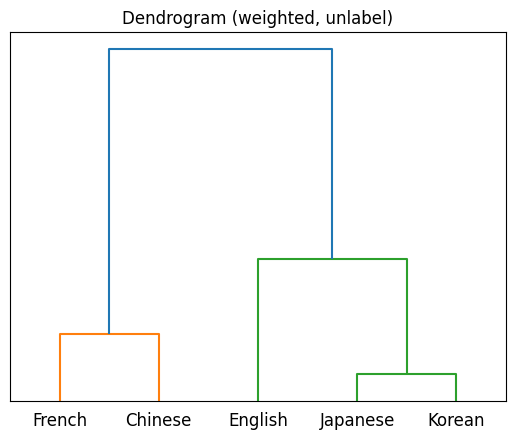

In [32]:
mat = np.array([
    [0.0, 2.9210620399488905, 3.909186519127199, 2.889577513517188, 4.022910527215509],
    [2.9210620399488905, 0.0, 1.6574226261167868, 0.6388610794329189, 1.9918164736164332],
    [3.909186519127199, 1.6574226261167868, 0.0, 6.481494471447322, 1.5812372912845252],
    [2.889577513517188, 0.6388610794329189, 6.481494471447322, 0.0, 10.241156247193615],
    [4.022910527215509, 1.9918164736164332, 1.5812372912845252, 10.241156247193615, 0.0]
])

condensed_distance = distance.squareform(mat)

linkage_matrix = linkage(condensed_distance, method="ward")

plt.figure()
dend = dendrogram(linkage_matrix, labels=["English", "Japanese", "French", "Korean", "Chinese"])
plt.yticks([])
plt.title("Dendrogram (weighted, unlabel)")

### ノードラベルを品詞にしたとき

In [4]:
CoNLLU_source_PATH = "corpora/French/French-GSD.conllu"
CoNLLU = pyconll.load_from_file(CoNLLU_source_PATH)
source_tree_count = len(CoNLLU)

CoNLLU_target_PATH = "corpora/Japanese/Japanese-GSDLUW.conllu"
CoNLLU += pyconll.load_from_file(CoNLLU_target_PATH)
target_tree_count = len(CoNLLU) - source_tree_count

print(source_tree_count, target_tree_count)

PQ_Trees = [trees.conllTree_to_pqTree_upos(conll.to_tree()) for conll in CoNLLU]
PQ_Index = [Profile(tree, p=2, q=2) for tree in PQ_Trees]

J = set(PQ_Index[0])
for pq_set  in PQ_Index[1:]:
    J = J.union(pq_set)
J = list(J)

tensors_source = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[:source_tree_count], desc="[convert tensor]")]
tensors_target = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[source_tree_count:], desc="[convert tensor]")]


model_path = "models/model_French-GSD_Japanese-GSDLUW_upos_50.pth"
distance_function = w_pq.WeightedPqgramDistance(tensors_source[0].size(), [], [])
distance_function.load_state_dict(torch.load(model_path))
distance_function.eval()
weights = distance_function.weights

a = []
for _ in range(source_tree_count):
    a.append(1/source_tree_count)
b = []
for _ in range(target_tree_count):
    b.append(1/target_tree_count)

cost_matrix = torch.zeros((source_tree_count, target_tree_count))

tensors_source = torch.stack([t.to("cuda:0") for t in tensors_source])
tensors_target = torch.stack([t.to("cuda:0") for t in tensors_target])


for i in tqdm(range(source_tree_count), desc="[cost matrix]"):
    t_source = tensors_source[i].unsqueeze(0)
    cost_matrix[i] = w_pq.weighted_pqgram_distance_batch(weights, tensors_target, t_source.repeat(tensors_target.size(0), 1)).to("cpu")


print(ot.emd2(a, b, cost_matrix.detach().numpy(), numItermax=1000000))

14450 8100


[convert tensor]:   0%|          | 0/14450 [00:00<?, ?it/s]

[convert tensor]:   0%|          | 0/8100 [00:00<?, ?it/s]

[cost matrix]:   0%|          | 0/14450 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 23.65 GiB of which 188.25 MiB is free. Process 161512 has 6.32 GiB memory in use. Including non-PyTorch memory, this process has 17.13 GiB memory in use. Of the allocated memory 16.60 GiB is allocated by PyTorch, and 98.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### 学習しないでやると

In [45]:
CoNLLU_source_PATH = "corpora/French/French-GSD.conllu"
CoNLLU = pyconll.load_from_file(CoNLLU_source_PATH)
source_tree_count = len(CoNLLU)

CoNLLU_target_PATH = "corpora/Chinese/Chinese-GSD.conllu"
CoNLLU += pyconll.load_from_file(CoNLLU_target_PATH)
target_tree_count = len(CoNLLU) - source_tree_count

print(source_tree_count, target_tree_count)

PQ_Trees = [trees.conllTree_to_pqTree_unlabeled(conll.to_tree()) for conll in CoNLLU]
PQ_Index = [Profile(tree, p=2, q=2) for tree in PQ_Trees]

J = set(PQ_Index[0])
for pq_set  in PQ_Index[1:]:
    J = J.union(pq_set)
J = list(J)

tensors_source = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[:source_tree_count], desc="[convert tensor]")]
tensors_target = [pq_gram.pqgram_to_tensor(pqgram, J) for pqgram in tqdm(PQ_Index[source_tree_count:], desc="[convert tensor]")]

weights = torch.ones(len(J))

a = []
for _ in range(source_tree_count):
    a.append(1/source_tree_count)
b = []
for _ in range(target_tree_count):
    b.append(1/target_tree_count)

cost_matrix = torch.zeros((source_tree_count, target_tree_count))

tensors_source = torch.stack([t.to("cuda:3") for t in tensors_source])
tensors_target = torch.stack([t.to("cuda:3") for t in tensors_target])

for i in tqdm(range(source_tree_count), desc="[cost matrix]"):
    t_source = tensors_source[i].unsqueeze(0)
    cost_matrix[i] = w_pq.weighted_pqgram_distance_batch(weights, tensors_target, t_source.repeat(tensors_target.size(0), 1))

print(ot.emd2(a, b, cost_matrix.detach().numpy(), numItermax=1000000))

14450 3997


[convert tensor]:   0%|          | 0/14450 [00:00<?, ?it/s]

[convert tensor]:   0%|          | 0/3997 [00:00<?, ?it/s]

[cost matrix]:   0%|          | 0/14450 [00:00<?, ?it/s]

6.305707212931308


Text(0.5, 1.0, 'Dendrogram (pure-$pq$gram, unlabel)')

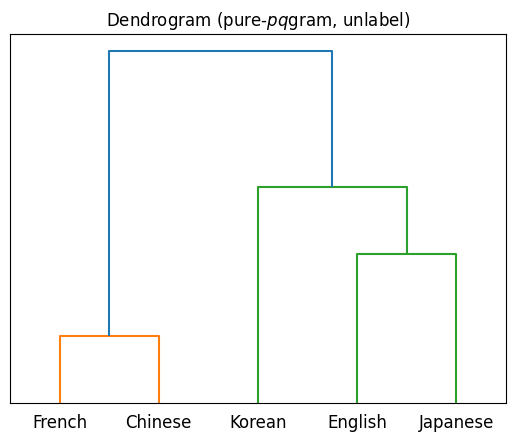

In [48]:
mat = np.array([
    [0.0,   13.921808713761822, 24.462756607012043,	16.37367393637651,	24.727866582687017],
    [13.921808713761822,	0.0,	13.283233099995035,	20.98275578765745,	15.733250120095386],
    [24.462756607012043,	13.283233099995035,	0.0,	27.790417556951798,	6.305707212931308],
    [16.37367393637651,	20.98275578765745,	27.790417556951798,	0.0,	30.96447059833724],
    [24.727866582687017,	15.733250120095386,	6.305707212931308,	30.96447059833724,	0.0]
])

condensed_distance = distance.squareform(mat)

linkage_matrix = linkage(condensed_distance, method="ward")

plt.figure()
dend = dendrogram(linkage_matrix, labels=["English", "Japanese", "French", "Korean", "Chinese"])
plt.yticks([])
plt.title(r"Dendrogram (pure-$pq$gram, unlabel)")

### TED ならどうなる？

In [52]:
CoNLLU_source_PATH = "corpora/French/French-GSD.conllu"
CoNLLU_src = random.sample(pyconll.load_from_file(CoNLLU_source_PATH), k=100)
source_tree_count = len(CoNLLU_src)

CoNLLU_target_PATH = "corpora/Chinese/Chinese-GSD.conllu"
CoNLLU_tar = random.sample(pyconll.load_from_file(CoNLLU_target_PATH), k=100)
target_tree_count = len(CoNLLU_tar)

zss_trees_src = [trees.conllTree_to_zssNode_unlabel(conll.to_tree()) for conll in CoNLLU_src]
zss_trees_tar = [trees.conllTree_to_zssNode_unlabel(conll.to_tree()) for conll in CoNLLU_tar]

a = []
for _ in range(source_tree_count):
    a.append(1/source_tree_count)
b = []
for _ in range(target_tree_count):
    b.append(1/target_tree_count)

cost_matrix = torch.zeros((source_tree_count, target_tree_count))

for i, src in tqdm(enumerate(zss_trees_src), desc="[cost matrix]"):
    for j, tar in enumerate(zss_trees_tar):
        cost_matrix[i,j] = zss.simple_distance(src, tar)
        

print(ot.emd2(a, b, cost_matrix.detach().numpy(), numItermax=1000000))

[cost matrix]: 0it [00:00, ?it/s]

11.339999746531248
